In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
import lightgbm as lgb
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
# Colabではコメントアウトを外す。

# from google.colab import drive
# drive.mount('/content/drive')

# GOOGLE_MY_DRIVE = "/content/drive/MyDrive/code/input/"


INPUT_DIR = "input/"

# INPUT_DIR = GOOGLE_MY_DRIVE

In [4]:
# Train/Valid/Testの区切りの定義
valid_start = datetime.datetime(2019, 1, 1)
pred_start = datetime.datetime(2020, 1, 1)
pred_end = datetime.datetime(2021, 1, 1)

In [5]:
def plot_prediction(df_eval):
    actual = df_eval['y']
    pred = df_eval['pred']
    
    mape = (np.abs(pred - actual) / actual * 100).mean()

    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.legend()
    plt.show()
    
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

In [6]:
def plot_feature_importance(df, title=None):
    plt.figure(figsize=(10,10))
    n_features = len(df) # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
    plt.barh(range(n_features), df_plot['importance'].values) 
    cols_plot = df_plot['feature'].values # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot) # x軸,y軸の値の設定
    plt.xlabel('Feature importance', fontsize=14)                  # x軸のタイトル
    plt.ylabel('Feature', fontsize=14)
    plt.tick_params(labelsize=14)
    if title != None:
        plt.title(f"{title}", fontsize=14)
    plt.show()

In [7]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

# 予測対象日前日までのデータが使えると仮定

In [8]:
target = ['y']
features = []

#  電力データ読み込み
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

# 気温データ読み込み
df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])
features.append('temperature')

# GDPデータ読み込み
df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])
features.append('gdp')

# データの突合
df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')

# 週・曜日変数の追加
df['week'] = df['ds'].dt.isocalendar().week.astype('int')
features.append('week')
df['dayofweek'] = df['ds'].dt.dayofweek
features.append('dayofweek')

# 過去データ変数の追加
for l in range(1,15):
    df[f'y_shift_{l}d'] = df['y'].shift(l).bfill()
    df[f't_shift_{l}d'] = df['temperature'].shift(l).bfill()
    features.append(f'y_shift_{l}d')
    features.append(f't_shift_{l}d')
    
# Train/Valid/Testに分割
df_train = df[(df['ds'] < valid_start)]
df_valid = df[(df['ds'] < pred_start) & (df['ds'] >= valid_start)]
df_test = df[(df['ds']>= pred_start) & (df['ds'] < pred_end)]

# LGBM用のデータセット準備
lgb_train = lgb.Dataset(df_train[features], df_train[target])
lgb_valid = lgb.Dataset(df_valid[features], df_valid[target])
lgb_test = lgb.Dataset(df_test[features], df_test[target])

# 評価基準を設定 
params = {'metric' : 'rmse'}

In [9]:
model = lgb.train(params = params,
                  train_set = lgb_train,
                  num_boost_round = 1000,
                  valid_sets =lgb_valid,
                  verbose_eval=10,
                  early_stopping_rounds = 10
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7302
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 32
[LightGBM] [Info] Start training from score 32.543366
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 2.03173
[20]	valid_0's rmse: 1.38362
[30]	valid_0's rmse: 1.19611
[40]	valid_0's rmse: 1.12577
[50]	valid_0's rmse: 1.09951
[60]	valid_0's rmse: 1.08555
[70]	valid_0's rmse: 1.07488
[80]	valid_0's rmse: 1.06687
[90]	valid_0's rmse: 1.06481
[100]	valid_0's rmse: 1.06349
[110]	valid_0's rmse: 1.06074
[120]	valid_0's rmse: 1.05695
[130]	valid_0's rmse: 1.05334
[140]	valid_0's rmse: 1.05264
[150]	valid_0's rmse: 1.05119
[160]	valid_0's rmse: 1.04953
[170]	valid_0's rmse: 1.04983
[180]	valid_0's rmse: 1.0481
[190]	valid_0's rmse: 1.0479
[200]	valid_0's rmse: 1.04766
Early

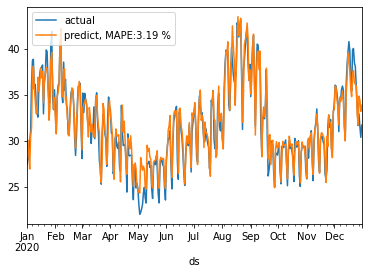

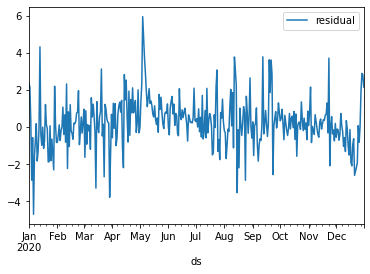

In [10]:
# 評価プロット
eval_cols = target + ['ds']
df_eval = df_test[eval_cols].copy()
df_eval['pred'] = model.predict(df_test[features])
df_eval = df_eval.set_index('ds')

plot_prediction(df_eval)

## 残差の確認

Jack Bera: 	 Jarque_beraResult(statistic=58.85616193211517, pvalue=1.6575629757653587e-13)


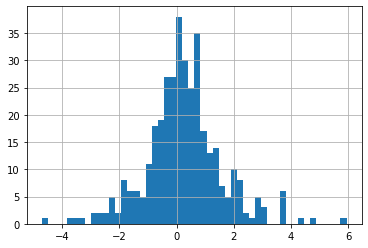

In [11]:
# 正規性の確認
diff_arr = df_eval['pred'] - df_eval['y']

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

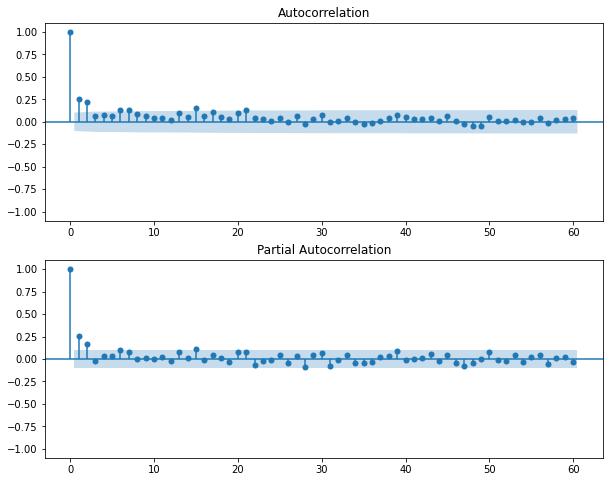

1 24.204495297610052 8.662984405502032e-07
2 42.79721380015356 5.08982795735095e-10
3 44.53400178148012 1.162233020533518e-09
4 46.80785550262764 1.6721031049336197e-09
5 48.245600904295046 3.1646194752843603e-09
6 54.46703065396719 5.938530145840185e-10
7 61.27014790935913 8.414410109068635e-11
8 63.85639498280898 8.119641666595247e-11
9 65.51915183739935 1.1432891133032404e-10
10 66.05690664297606 2.5434179441619227e-10


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [12]:
# 自己回帰の確認
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

---ctt---
(-10.523393727669141, 2.74827538802062e-16, 1, 364, {'1%': -4.403242980856316, '5%': -3.848711170118675, '10%': -3.5633551124006564}, 1130.1518939348405)
---ct---
(-9.693469704964109, 1.0491527943709468e-14, 1, 364, {'1%': -3.983858492918219, '5%': -3.422620677558916, '10%': -3.13418338427965}, 1135.8332106236903)
---c---
(-9.714526656528722, 9.911112035168015e-17, 1, 364, {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}, 1134.3615601256765)
---nc---
(-4.581682102133556, 6.663795428284698e-06, 6, 359, {'1%': -2.5719959973929436, '5%': -1.9417736239465488, '10%': -1.6161006771222244}, 1136.6769964822515)


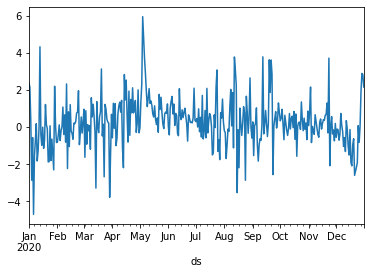

In [13]:
# 定常性の確認
y = diff_arr
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

##  特徴量重要度

In [22]:
importances = pd.DataFrame([features, model.feature_importance('gain')], index=['feature', 'importance']).T
importances.sort_values('importance', ascending=False)

,feature,importance
14,y_shift_7d,25576.431228
0,temperature,25056.640315
4,y_shift_2d,18227.792384
3,dayofweek,11388.610627
28,y_shift_14d,3301.174383
2,week,1769.177579
8,y_shift_4d,1442.043062
10,y_shift_5d,450.204894
6,y_shift_3d,449.435235
11,t_shift_5d,411.344711


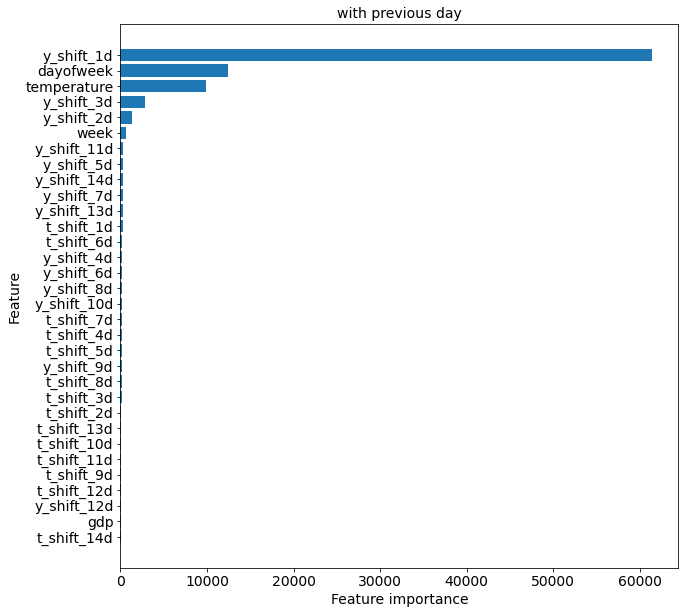

In [15]:
plot_feature_importance(importances, 'with previous day')

# 予測対象日前々日までのデータが使えると仮定

In [16]:
target = ['y']
features = []

#  電力データ読み込み
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

# 気温データ読み込み
df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])
features.append('temperature')

# GDPデータ読み込み
df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])
features.append('gdp')

# データの突合
df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')

df['week'] = df['ds'].dt.isocalendar().week.astype('int')
features.append('week')
df['dayofweek'] = df['ds'].dt.dayofweek
features.append('dayofweek')

# 過去データのカラムを追加
for l in range(2,15): # ラグを２からに修正
    df[f'y_shift_{l}d'] = df['y'].shift(l).bfill()
    df[f't_shift_{l}d'] = df['temperature'].shift(l).bfill()
    features.append(f'y_shift_{l}d')
    features.append(f't_shift_{l}d')
    
# Train/Valid/Testに分割
df_train = df[(df['ds'] < valid_start)]
df_valid = df[(df['ds'] < pred_start) & (df['ds'] >= valid_start)]
df_test = df[(df['ds']>= pred_start) & (df['ds'] < pred_end)]

# LGBM用のデータセット準備
lgb_train = lgb.Dataset(df_train[features], df_train[target])
lgb_valid = lgb.Dataset(df_valid[features], df_valid[target])
lgb_test = lgb.Dataset(df_test[features], df_test[target])

# 評価基準を設定 
params = {'metric' : 'rmse'}

In [17]:
# 予測モデル訓練
model = lgb.train(params = params,
                  train_set = lgb_train,
                  num_boost_round = 1000,
                  valid_sets =lgb_valid,
                  verbose_eval=10,
                  early_stopping_rounds = 10
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6803
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 30
[LightGBM] [Info] Start training from score 32.543366
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 2.23583
[20]	valid_0's rmse: 1.63401
[30]	valid_0's rmse: 1.44952
[40]	valid_0's rmse: 1.37813
[50]	valid_0's rmse: 1.33973
[60]	valid_0's rmse: 1.3224
[70]	valid_0's rmse: 1.30436
[80]	valid_0's rmse: 1.29537
[90]	valid_0's rmse: 1.28616
[100]	valid_0's rmse: 1.27968
[110]	valid_0's rmse: 1.27278
[120]	valid_0's rmse: 1.26616
[130]	valid_0's rmse: 1.26287
[140]	valid_0's rmse: 1.26207
[150]	valid_0's rmse: 1.26069
[160]	valid_0's rmse: 1.2593
[170]	valid_0's rmse: 1.25937
Early stopping, best iteration is:
[162]	valid_0's rmse: 1.25844


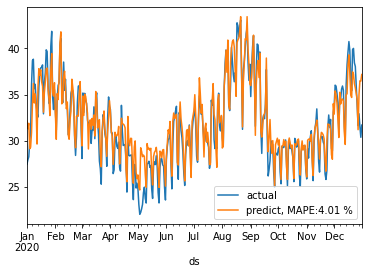

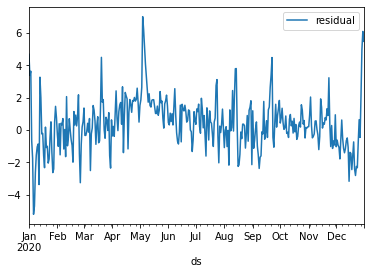

In [18]:
# 評価プロット
eval_cols = target + ['ds']
df_eval = df_test[eval_cols].copy()
df_eval['pred'] = model.predict(df_test[features])
df_eval = df_eval.set_index('ds')

plot_prediction(df_eval)

In [19]:
importances = pd.DataFrame([features, model.feature_importance('gain')], index=['feature', 'importance']).T
importances
# importances['gain'].sort_values(ascending=False)

,feature,importance
0,temperature,25056.640315
1,gdp,133.785919
2,week,1769.177579
3,dayofweek,11388.610627
4,y_shift_2d,18227.792384
5,t_shift_2d,326.073072
6,y_shift_3d,449.435235
7,t_shift_3d,249.251167
8,y_shift_4d,1442.043062
9,t_shift_4d,203.66886


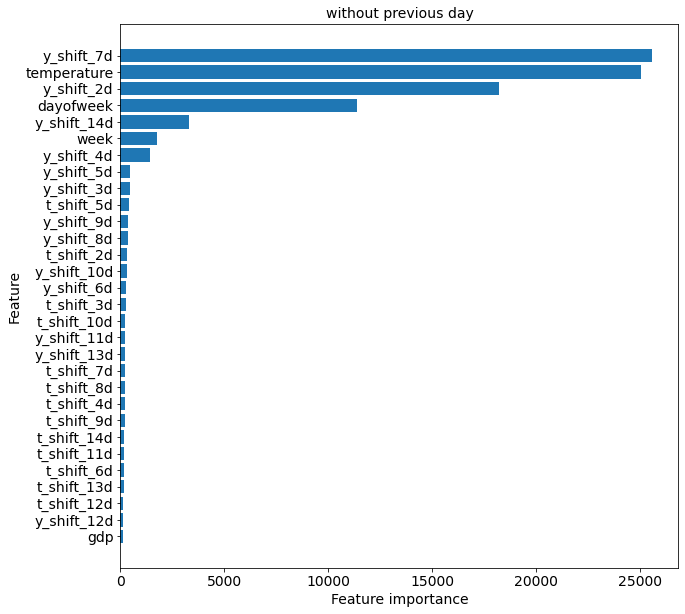

In [20]:
plot_feature_importance(importances, 'without previous day')